# Integrantes

- Catherine Balbuena Franco - 100088386
- Juan Manuel Sánchez Ortega - 1017249629

In [ ]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import timedelta

# ==============================================================================
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler

#creación de modelos
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

#Escalar Variables
from sklearn.preprocessing import MinMaxScaler

#import statsmodels.api as sm
import math
from scipy.optimize import curve_fit

#evaluacion de variables
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

#Creación de modelo
#import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing

## Objetivo
Mejorar la estimación de la cuantificación de la precipitación obtenida por métodos matemáticos proveniente de información del radar meteorológico operado por SIATA

![image-3.png](attachment:image-3.png) ![image-2.png](attachment:image-2.png)

Fuente: https://siata.gov.co/siata_nuevo/

## Cargar datasets de Datos

In [ ]:
def prepara_data(dataframe):
      '''
      Esta funcion permite eliminar las columnas del dataframe que no entraran al modelo
      '''
      dataframe = dataframe.drop(columns=['P_60', 'PPT_Calculated',
            'Altitud_Est', 'Dist_Radar', 'Intensidad_60min',
            'Intensidad_30min', 'Intensidad_10min','Intensidad',
            'Intensidad_5min','RainType_SHY95'])

      dataframe.index = pd.to_datetime(dataframe.index.strftime(
                        '%Y-%m-%d %H:%M:%S'))
      dataframe =  dataframe[dataframe['Intensidad_15min'] > 0]
      dataframe = dataframe.sort_index()

      return dataframe

def compute_percentiles(vector):
      '''
      Funcion para calcular percentiles
      '''
      #lluvia debiles < 90:
      perc_75 = np.percentile(vector, 90)
      #lluvia debiles >= 99:
      perc_95 = np.percentile(vector, 99)
      return perc_75, perc_95

In [ ]:
path_files = '/home/jsanchezo/RADAR/Codigos/Machine_Learning/Datasets/'
path_save = '/home/jsanchezo/RADAR/Codigos/Machine_Learning/Imagenes/'
#Asi se carga el archisame_event
ruta = f'{path_files}dataset_radar_completo.pkl'
with open(ruta, 'rb') as fp:
   dataset = pickle.load(fp)

dataset.info()
dataset.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 457680 entries, 2015-01-01 00:07:00 to 2019-12-31 18:56:00
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   P_60                    456407 non-null  float64
 1   PPT_Calculated          456407 non-null  float32
 2   PPI_Reflectivity_point  31414 non-null   float32
 3   PPI_Reflectivity_area   48552 non-null   float32
 4   CAPPI_Reflectivity      30372 non-null   float32
 5   RainType_SHY95          28307 non-null   float32
 6   Altitud_Est             457680 non-null  float64
 7   Dist_Radar              457680 non-null  float64
 8   Intensidad              456407 non-null  float64
dtypes: float32(5), float64(4)
memory usage: 26.2 MB


,P_60,PPT_Calculated,PPI_Reflectivity_point,PPI_Reflectivity_area,CAPPI_Reflectivity,RainType_SHY95,Altitud_Est,Dist_Radar,Intensidad
time,,,,,,,,,
2019-12-31 18:35:00,0.0,0.0,NaN,NaN,NaN,NaN,1540.0,9.99,0.0
2019-12-31 18:40:00,0.0,0.0,NaN,NaN,NaN,NaN,1540.0,9.99,0.0
2019-12-31 18:45:00,0.0,0.0,NaN,NaN,NaN,NaN,1540.0,9.99,0.0
2019-12-31 18:51:00,0.0,0.0,NaN,1.000000,NaN,NaN,1540.0,9.99,0.0
2019-12-31 18:56:00,0.0,0.0,NaN,6.595239,6.425564,1.0,1540.0,9.99,0.0


## Preprocesamiento de Datos

In [ ]:
#Nos quedamos con los datos donde se registro lluvia
lluvia= dataset[(dataset['P_60'] > 0) &(dataset['PPI_Reflectivity_area'].notnull())
          & (dataset['PPI_Reflectivity_area']>0)]
#Eliminar las filas del index repetidas
lluvia = lluvia[~lluvia.index.duplicated(keep='first')]
lluvia.head()

,P_60,PPT_Calculated,PPI_Reflectivity_point,PPI_Reflectivity_area,CAPPI_Reflectivity,RainType_SHY95,Altitud_Est,Dist_Radar,Intensidad
time,,,,,,,,,
2015-01-20 14:47:00,0.508,0.489113,26.000000,20.109055,25.999403,1.0,1540.0,9.99,6.096
2015-01-21 01:38:00,0.254,0.435064,24.333334,21.788067,24.332907,1.0,1540.0,9.99,3.048
2015-01-21 02:12:00,0.254,0.295248,9.333333,11.527396,9.334458,1.0,1540.0,9.99,3.048
2015-01-21 02:58:00,0.254,0.000000,5.750000,7.449771,5.750515,1.0,1540.0,9.99,3.048
2015-01-21 17:28:00,0.762,0.350666,19.833334,20.026749,19.833252,1.0,1540.0,9.99,9.144


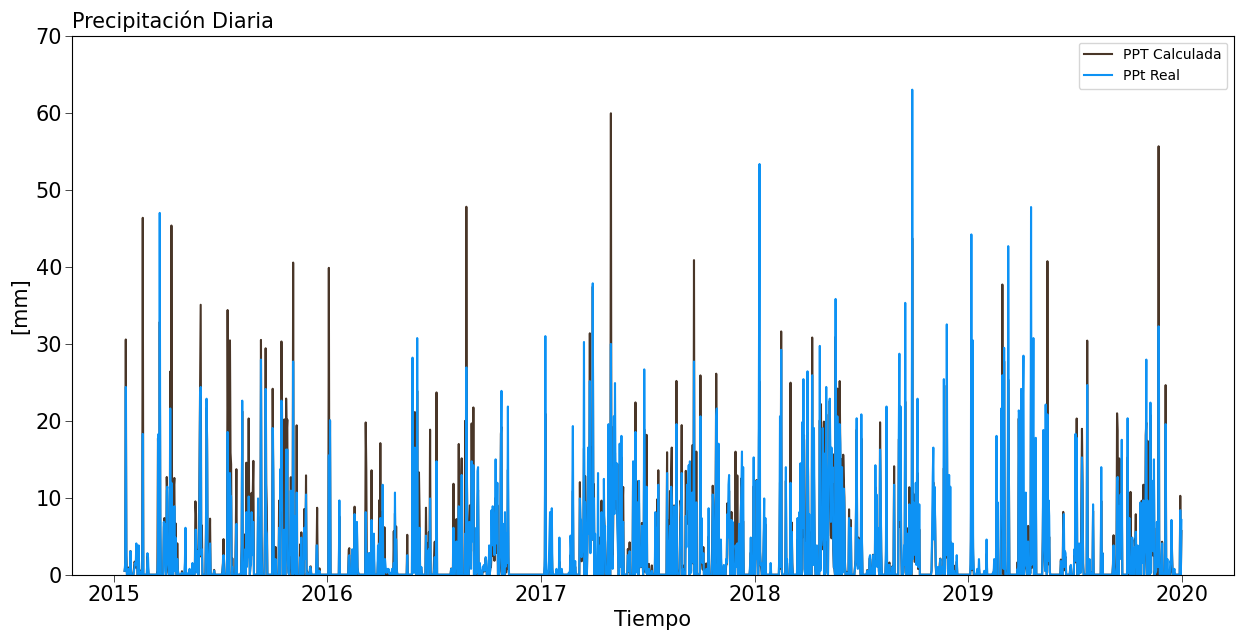

In [ ]:
acum_day = lluvia.resample('D').sum()
# days = pd.date_range(acum_day.index[0],acum_day.index[-1], freq='D')

#Grafica de la PPT calculada VS Pluviometro
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)

ax.plot(acum_day.PPT_Calculated, color = '#493628',
        label = 'PPT Calculada')
ax.plot(acum_day.P_60, color = '#0D92F4',
        label = 'PPt Real')

ax.tick_params(labelsize=15, width = 0.5, length=5, pad = 2)

ax.set_ylabel('[mm]', fontsize = 15)
ax.set_xlabel('Tiempo', fontsize = 15)
ax.set_title('Precipitación Diaria', loc='left', fontsize = 15)
ax.set_ylim(0,70)
ax.legend(loc = 1)

#### Calculamos nuevas variables a partir de información de Pluviometros

In [ ]:
#Vamos a calcular la intensidad usando los datos origi de pluvio
# Para una sola estacion

#Cargamos los datos minutales de los pluviometros
dataset_pluvio = pd.read_csv(f'{path_files}Datos_Pluviometro_60.csv',
                             index_col = 'Unnamed: 0')
dataset_pluvio

## Se realizó y se guardó en un archivo externo por costo computacional, como se ve a continuación:

# min60 = []
# min30 = []
# min15 = []
# min10 = []
# min5 = []

# filtro = 'si'
# for d,date in enumerate(lluvia.index):
#     # Ingresa las variables iniciales
#     fec_ini = date - timedelta(minutes=60)
#     fec_fin = date


#     df_pluvio = dataset_pluvio.loc[str(fec_ini):str(fec_fin)]

#     #Calculamos la intensidad mm/h
#     min60.append(df_pluvio.sum().P)
#     #Calculamos la intensidad mm/h en 30 min
#     min30.append((df_pluvio.iloc[-30:].sum().P*60)/30)
#     #Calculamos la intensidad mm/h en 15 min
#     min15.append((df_pluvio.iloc[-15:].sum().P*60)/15)
#     #Calculamos la intensidad mm/h en 10 min
#     min10.append((df_pluvio.iloc[-10:].sum().P*60)/10)
#     #Calculamos la intensidad mm/h en 5 min
#     min5.append((df_pluvio.iloc[-5:].sum().P*60)/5)

# lluvia['Intensidad_60min'] = min60
# lluvia['Intensidad_30min'] = min30
# lluvia['Intensidad_15min'] = min15
# lluvia['Intensidad_10min'] = min10
# lluvia['Intensidad_5min'] = min5

# #Asi se guarda el diccionario
# ruta = f'{path_files}dataset_radar_Intensidades.pkl'
# with open(ruta, 'wb') as archivo:
#     pickle.dump(lluvia, archivo)


,codigo,fecha_hora,P,calidad
2015-01-01 00:00:00,NaN,NaN,NaN,NaN
2015-01-01 00:01:00,NaN,NaN,NaN,NaN
2015-01-01 00:02:00,NaN,NaN,NaN,NaN
2015-01-01 00:03:00,NaN,NaN,NaN,NaN
2015-01-01 00:04:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2019-12-31 23:55:00,60.0,2019-12-31 23:55:00,0.0,1.0
2019-12-31 23:56:00,60.0,2019-12-31 23:56:00,0.0,1.0
2019-12-31 23:57:00,60.0,2019-12-31 23:57:00,0.0,1.0
2019-12-31 23:58:00,60.0,2019-12-31 23:58:00,0.0,1.0


In [ ]:
#Agregamos columnas de intensidad en diferentes ventanas de tiempo
#esta informacion fue obtenida directamente desde SIATA

#Asi se carga el archisame_event
ruta = f'{path_files}dataset_radar_Intensidades.pkl'
with open(ruta, 'rb') as fp:
   ds_intensidad = pickle.load(fp)
ds_intensidad.head()

,P_60,PPT_Calculated,PPI_Reflectivity_point,PPI_Reflectivity_area,CAPPI_Reflectivity,RainType_SHY95,Altitud_Est,Dist_Radar,Intensidad,Intensidad_60min,Intensidad_30min,Intensidad_15min,Intensidad_10min,Intensidad_5min
time,,,,,,,,,,,,,,
2015-01-20 14:47:00,0.508,0.489113,26.000000,20.109055,25.999403,1.0,1540.0,9.99,6.096,1.524,3.048,6.096,6.096,3.048
2015-01-21 01:38:00,0.254,0.435064,24.333334,21.788067,24.332907,1.0,1540.0,9.99,3.048,0.254,0.508,1.016,1.524,0.000
2015-01-21 02:12:00,0.254,0.295248,9.333333,11.527396,9.334458,1.0,1540.0,9.99,3.048,0.508,0.508,1.016,1.524,3.048
2015-01-21 02:58:00,0.254,0.000000,5.750000,7.449771,5.750515,1.0,1540.0,9.99,3.048,0.508,0.508,1.016,1.524,0.000
2015-01-21 17:28:00,0.762,0.350666,19.833334,20.026749,19.833252,1.0,1540.0,9.99,9.144,1.016,2.032,4.064,6.096,9.144


In [ ]:
ds_intensidad['Intensidad_15min'] = np.log1p(ds_intensidad['Intensidad_15min'])

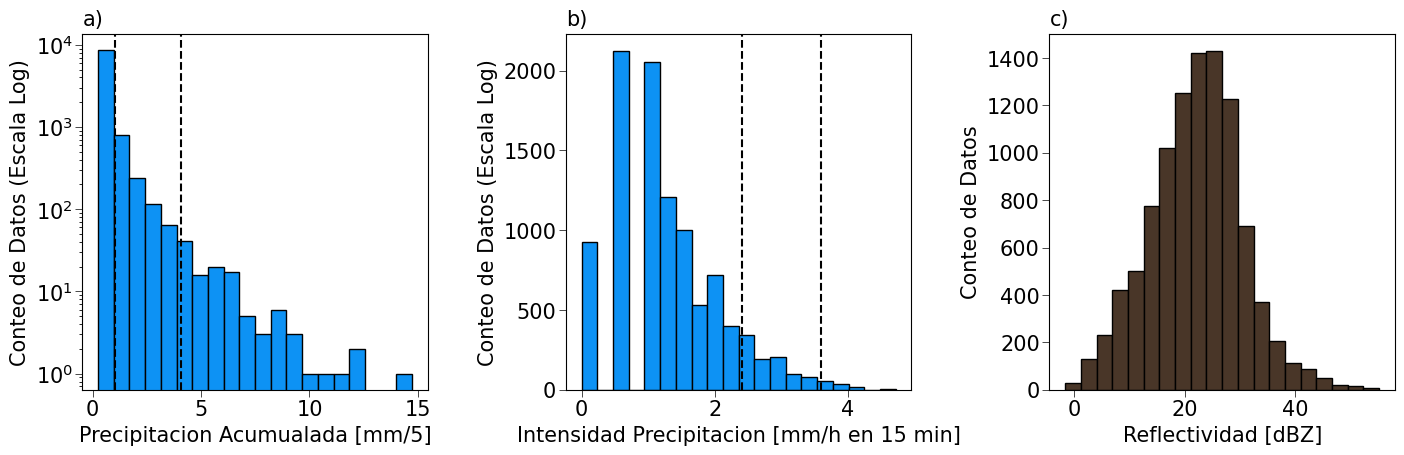

In [ ]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(131)

acum_90, acum_99 = compute_percentiles(ds_intensidad['P_60'].values)
ax.hist(ds_intensidad['P_60'], bins=20, color='#0D92F4', edgecolor='black')
ax.axvline(acum_90, ls = '--', color = '#000000', lw = 1.5)
ax.axvline(acum_99, ls = '--', color = '#000000', lw = 1.5)

ax.set_title('a)', loc='left', fontsize = 15)
ax.set_yscale('log')
ax.set_xlabel('Precipitacion Acumualada [mm/5]', fontsize = 15)
ax.set_ylabel('Conteo de Datos (Escala Log)', fontsize = 15)
ax.tick_params(labelsize=15, width = 0.5, length=5, pad = 2)

ax = fig.add_subplot(132)

ax.hist(ds_intensidad['Intensidad_15min'], bins=20, color='#0D92F4', edgecolor='black')

inte_90, inte_99 = compute_percentiles(ds_intensidad['Intensidad_15min'].values)
ax.axvline(inte_90, ls = '--', color = '#000000', lw = 1.5)
ax.axvline(inte_99, ls = '--', color = '#000000', lw = 1.5)

#ax.set_yscale('log')
ax.set_title('b)', loc='left', fontsize = 15)
ax.set_xlabel('Intensidad Precipitacion [mm/h en 15 min]', fontsize = 15)
ax.set_ylabel('Conteo de Datos (Escala Log)', fontsize = 15)
ax.tick_params(labelsize=15, width = 0.5, length=5, pad = 2)

ax = fig.add_subplot(133)

ax.hist(ds_intensidad['PPI_Reflectivity_point'], bins=20, color='#493628', edgecolor='black')

ax.set_title('c)', loc='left', fontsize = 15)
ax.set_xlabel('Reflectividad [dBZ]', fontsize = 15)
ax.set_ylabel('Conteo de Datos', fontsize = 15)
ax.tick_params(labelsize=15, width = 0.5, length=5, pad = 2)

plt.subplots_adjust(right=2, top =1,wspace=.4)
plt.savefig(f'{path_save}Histogramas.png',
            bbox_inches="tight",dpi = 200)

Existe una fuerte diferencia entre la cantidad de datos con acumulados/intensidades bajas respecto a la cantidad de datos con intensidades altas, construiremos 3 datasets, para entrenar tres modelos diferentes que se ajusten a el tipo de precipitacion.
Para esto consideramos 3 tipos de eventos:
- Eventos Debiles: Aquellos cuya intensidad está por debajo del percentil 90 del dataset completo.
- Eventos Moderados: Aquellos cuya intensidad está entre el percentil 90 y el 99 del dataset completo.
- Eventos Debiles: Aquellos cuya intensidad está por encima del percentil 99 del dataset completo.

In [ ]:
ds_NoColumn = prepara_data(ds_intensidad)

#Contruccion de los nuevos datasets
Debiles = ds_NoColumn[ds_NoColumn.Intensidad_15min < inte_90]
Moderados = ds_NoColumn[(ds_NoColumn.Intensidad_15min >= inte_90)&
            (ds_NoColumn.Intensidad_15min <= inte_99)]
Fuertes = ds_NoColumn[ds_NoColumn.Intensidad_15min > inte_99]

In [ ]:
Moderados.head()

,PPI_Reflectivity_point,PPI_Reflectivity_area,CAPPI_Reflectivity,Intensidad_15min
time,,,,
2015-01-22 20:43:00,31.833334,36.322788,31.835354,2.412336
2015-01-22 21:00:00,20.166666,20.608694,20.608694,2.905370
2015-01-22 21:11:00,17.250000,21.501141,17.252405,2.959483
2015-02-09 17:28:00,21.333334,24.940252,21.335363,2.579611
2015-02-09 17:33:00,13.500000,14.542553,13.500591,2.579611


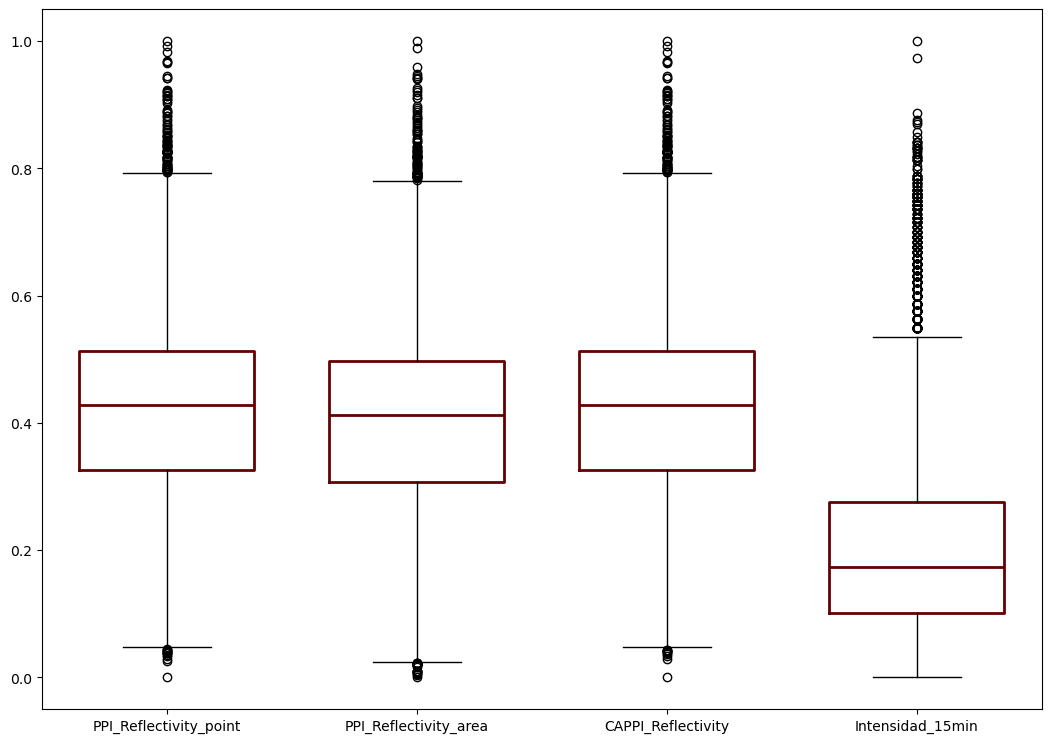

In [ ]:
#Objeto MinMaxScaler
scaler = MinMaxScaler()

#Escalamos el DF
df_scaled = scaler.fit_transform(ds_NoColumn)

# Paso 4: Crear un nuevo DataFrame con los datos escalados
df_scaled = pd.DataFrame(df_scaled, columns=ds_NoColumn.columns)

fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
#patch_artist=True
variables = df_scaled.columns
boxprops1 = dict(linestyle='-', linewidth=2, color = '#630000')

for v,var in enumerate(variables):
    data_dummy = df_scaled[var].dropna()
    bp1 = ax.boxplot(data_dummy,positions=[v],widths = 0.7,
                    boxprops=boxprops1, medianprops=boxprops1)
ax.set_xticklabels(variables)
plt.savefig(f'{path_save}BoxPlot_Variables.png',
            bbox_inches="tight",dpi = 200)

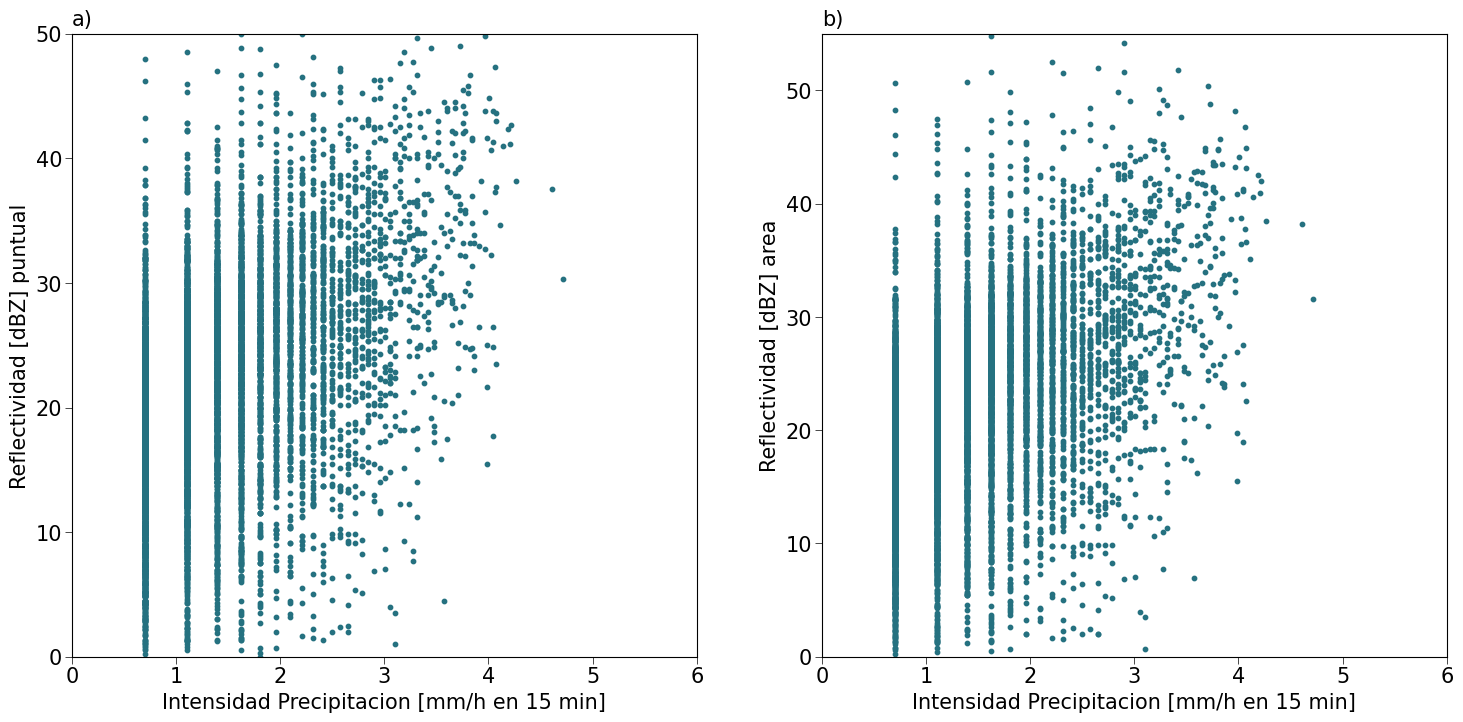

In [ ]:
#Scatter de la Reflec VS Pluviometro
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(121)

a = 28.493
b = 1.013

Reflect_equi_point = a*ds_NoColumn.Intensidad_15min.values**b

scatter = ax.scatter(ds_NoColumn.Intensidad_15min.values,
                    ds_NoColumn.PPI_Reflectivity_point.values,
                    s= 10, color = '#257180')

ax.tick_params(labelsize=15, width = 0.5, length=5, pad = 2)
ax.set_title('a)', loc='left', fontsize = 15)
ax.set_ylabel('Reflectividad [dBZ] puntual', fontsize = 15)
ax.set_xlabel('Intensidad Precipitacion [mm/h en 15 min]', fontsize = 15)
ax.set_ylim(0,50)
ax.set_xlim(0,6)
#========

ax = fig.add_subplot(122)

scatter = ax.scatter(ds_NoColumn.Intensidad_15min.values,
                    ds_NoColumn.PPI_Reflectivity_area.values,
                    s= 10, color = '#257180')


ax.tick_params(labelsize=15, width = 0.5, length=5, pad = 2)

ax.set_title('b)', loc='left', fontsize = 15)
ax.set_ylabel('Reflectividad [dBZ] area', fontsize = 15)
ax.set_xlabel('Intensidad Precipitacion [mm/h en 15 min]', fontsize = 15)
ax.set_ylim(0,55)
ax.set_xlim(0,6)

plt.subplots_adjust(right=1.5, top =1,wspace=.2)
plt.savefig(f'{path_save}ScatterPlots_Intensidades.png',
            bbox_inches="tight",dpi = 200)

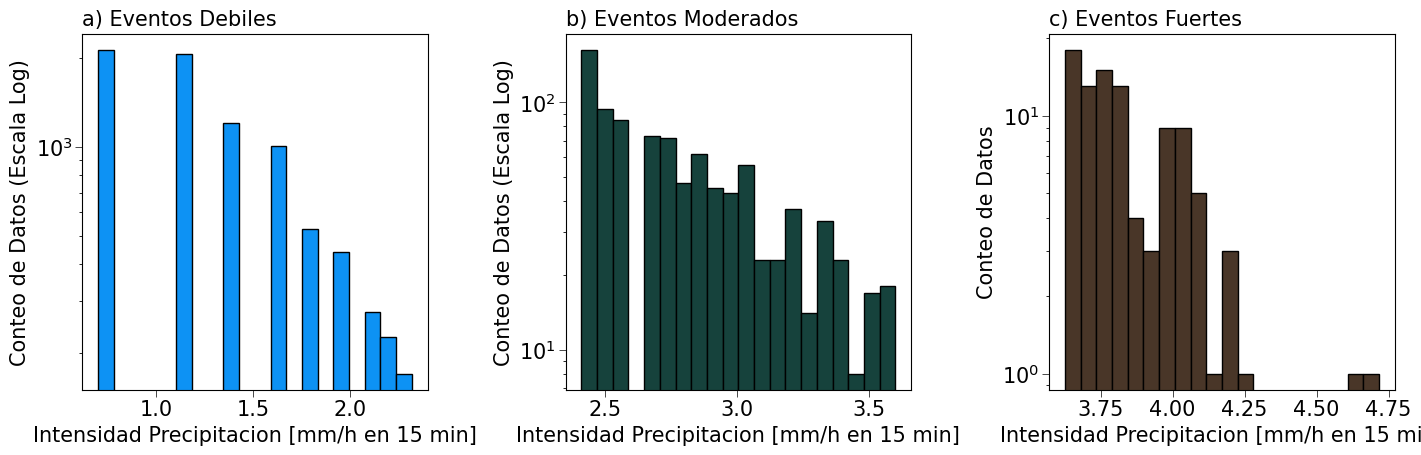

In [ ]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(131)

ax.set_title('a) Eventos Debiles', fontsize = 15, loc ='left')
ax.hist(Debiles['Intensidad_15min'], bins=20, color='#0D92F4', edgecolor='black')

ax.set_yscale('log')
ax.set_xlabel('Intensidad Precipitacion [mm/h en 15 min]', fontsize = 15)
ax.set_ylabel('Conteo de Datos (Escala Log)', fontsize = 15)
ax.tick_params(labelsize=15, width = 0.5, length=5, pad = 2)

ax = fig.add_subplot(132)

ax.set_title('b) Eventos Moderados', fontsize = 15, loc ='left')
ax.hist(Moderados['Intensidad_15min'], bins=20, color='#16423C', edgecolor='black')

ax.set_yscale('log')
ax.set_xlabel('Intensidad Precipitacion [mm/h en 15 min]', fontsize = 15)
ax.set_ylabel('Conteo de Datos (Escala Log)', fontsize = 15)
ax.tick_params(labelsize=15, width = 0.5, length=5, pad = 2)

ax = fig.add_subplot(133)

ax.set_title('c) Eventos Fuertes', fontsize = 15, loc ='left')
ax.hist(Fuertes['Intensidad_15min'], bins=20, color='#493628', edgecolor='black')

ax.set_yscale('log')
ax.set_xlabel('Intensidad Precipitacion [mm/h en 15 min]', fontsize = 15)
ax.set_ylabel('Conteo de Datos', fontsize = 15)
ax.tick_params(labelsize=15, width = 0.5, length=5, pad = 2)

plt.subplots_adjust(right=2, top =1,wspace=.4)
plt.savefig(f'{path_save}Histogramas_Eventos_Categorizados.png',
            bbox_inches="tight",dpi = 200)

In [ ]:
#Tamaño de los nuevos datasets
len(Debiles), len(Moderados), len(Fuertes)

(8034, 936, 96)